# intersect microexons by human-specific gaps, insertions, substitutions

input 

- MSA 30-way all human gaps/insertions/subs bed
    - formatted from ./2_format_subs_indels.ipynb
    
- microexon bed 
    - formatted from ./0_microexon-to-bed.ipynb
    
method
   - pybedtool intersection: microexon x hu-specific subs/gaps/ins
       - write microexon info, write hu-specific subs/gaps/ins info
       
   - write intersection file
   
   - inspect microexon overlapping variants
   
   - inspect microexon intron/exon variants
   
   
return
   - intersection file

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pbt
import seaborn as sns
sys.path.append("/wynton/home/ahituv/fongsl/tools/py_")
import config_readwrite as crw

config_tag = "config.ini"
config, configfile_name = crw.read_config(os.path.join(os.getcwd(), config_tag))

PATH = config["hu-specific"]["path"]
ALL = config["hu-specific"]["file"]
ME = config["microexon"]["bed"]

## write outfile

In [4]:
OUT = "/wynton/home/ahituv/fongsl/microexons/data/human.hg38.total_detected_truncated_x_HUSP.bed"

# add out file to config
crw.check_section(config, "hu_x_me")
config["hu_x_me"]["bed"]=OUT
crw.write_config(config, configfile_name )

## load bed objects 

In [5]:
bed = pbt.BedTool(ALL)
me = pbt.BedTool(ME)

## intersect human-specific deletions with microexon

In [6]:
intr = me.intersect(bed, output=OUT, wa=True, wb=True)

## inspect microexons

In [17]:
# check column names
if "#chr" not in list(pd.read_csv(OUT, sep = '\t', nrows=2)):
    
    # if columns not named, name cols
    cols = ["#chr", "startMe", "endMe", "geneName", "label", 
            "#chrVar", "startVar", "endVar", "nSpecies", 
            "mafStart", "mafLen","species", "mut", "mutLen", "id"]
    
    # open out file, drop duplicates
    df = pd.read_csv(OUT, sep='\t', header=None).drop_duplicates()
    
    # rename cols
    df.columns=cols
    
    # re-save outfile
    df.to_csv(OUT, sep='\t', index=False)
else:
    df = pd.read_csv(OUT, sep='\t').drop_duplicates()

In [18]:
df.head()

,#chr,startMe,endMe,geneName,label,#chrVar,startVar,endVar,nSpecies,mafStart,mafLen,species,mut,mutLen,id
0,chr22,35954273,35954283,RBFOX2,microexon,chr22,35954281,35954282,28,35954255,299,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr22:35954281-35954282
1,chr18,55601917,55601921,TCF4,microexon,chr18,55601919,55601920,24,55601867,60,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr18:55601919-55601920
2,chr6,79203033,79203047,HMGN3,microexon,chr6,79203033,79203034,29,79202977,140,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr6:79203033-79203034
3,chr3,16511156,16511159,RFTN1,microexon,chr3,16511156,16511157,30,16511069,369,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr3:16511156-16511157
4,chr3,56448386,56448390,ERC2,microexon,chr3,56448387,56448388,29,56448252,244,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr3:56448387-56448388


# how many microexon overlaps are there?  

In [19]:
df.groupby("label")["id"].count()

label
dsINT        200727
microexon        52
upINT        224381
Name: id, dtype: int64

## what kind of mutations overlap microexons? 

In [34]:
label_mut = df.groupby(["label", "mut"])["id"].count().reset_index()
label_mut

,label,mut,id
0,dsINT,DEL,10578
1,dsINT,INS,9102
2,dsINT,SUB,181047
3,microexon,DEL,5
4,microexon,INS,1
5,microexon,SUB,46
6,upINT,DEL,11637
7,upINT,INS,9846
8,upINT,SUB,202898


[Text(0, 0.5, 'count')]

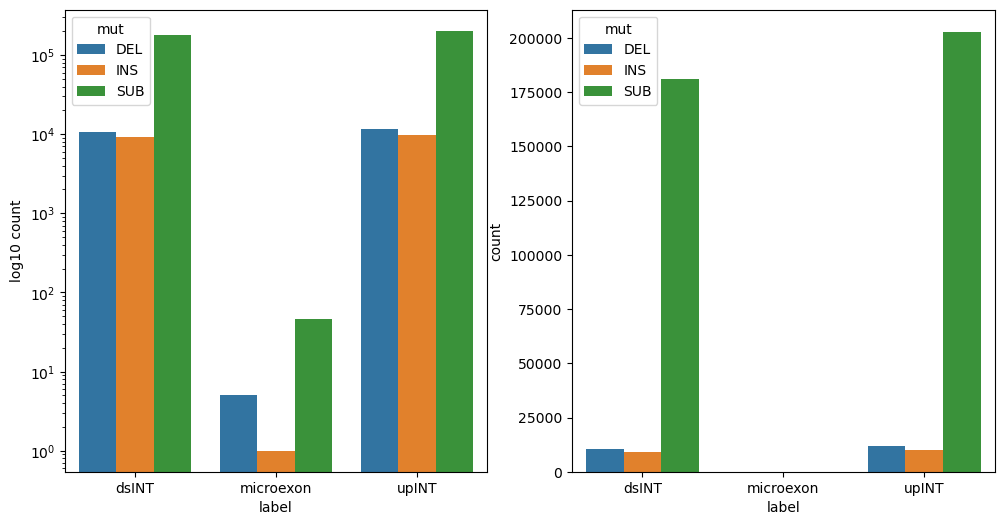

In [42]:
fig,(ax, ax2) = plt.subplots(ncols = 2, figsize = (12,6))
sns.barplot(data=label_mut, x ="label", hue="mut", y="id", ax=ax)
ax.set(yscale = 'log', 
      ylabel = "log10 count")
sns.barplot(data=label_mut, x ="label", hue="mut", y="id", ax=ax2)
ax2.set(ylabel = "count")


## inspect Dels

In [23]:
df.loc[(df["label"]== 'microexon') & (df["mut"]=="DEL")]

,#chr,startMe,endMe,geneName,label,#chrVar,startVar,endVar,nSpecies,mafStart,mafLen,species,mut,mutLen,id
9,chr20,5571014,5571031,GPCPD1,microexon,chr20,5571022,5571023,23,5570792,349,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",DEL,3,chr20:5571022-5571023
12,chr9,40228343,40228365,ANKRD20A2,microexon,chr9,40228343,40228344,16,40228121,273,"hg38,panPan2,gorGor5,nomLeu3,rheMac8,macFas5,m...",DEL,1,chr9:40228343-40228344
20,chr4,77928045,77928067,MRPL1,microexon,chr4,77928045,77928046,27,77927783,809,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",DEL,1,chr4:77928045-77928046
36,chr17,12095462,12095466,MAP2K4,microexon,chr17,12095465,12095466,30,12095134,428,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",DEL,4,chr17:12095465-12095466
43,chr2,241684501,241684508,DTYMK,microexon,chr2,241684505,241684506,20,241684465,280,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",DEL,8,chr2:241684505-241684506


## inspect INS 

In [25]:
df.loc[(df["label"]== 'microexon') & (df["mut"]=="INS")]

,#chr,startMe,endMe,geneName,label,#chrVar,startVar,endVar,nSpecies,mafStart,mafLen,species,mut,mutLen,id
35,chr8,124496879,124496901,TATDN1,microexon,chr8,124496884,124496885,21,124496718,272,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",INS,1,chr8:124496884-124496885


## inspect subs

In [24]:
df.loc[(df["label"]== 'microexon') & (df["mut"]=="SUB")]

,#chr,startMe,endMe,geneName,label,#chrVar,startVar,endVar,nSpecies,mafStart,mafLen,species,mut,mutLen,id
0,chr22,35954273,35954283,RBFOX2,microexon,chr22,35954281,35954282,28,35954255,299,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr22:35954281-35954282
1,chr18,55601917,55601921,TCF4,microexon,chr18,55601919,55601920,24,55601867,60,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr18:55601919-55601920
2,chr6,79203033,79203047,HMGN3,microexon,chr6,79203033,79203034,29,79202977,140,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr6:79203033-79203034
3,chr3,16511156,16511159,RFTN1,microexon,chr3,16511156,16511157,30,16511069,369,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr3:16511156-16511157
4,chr3,56448386,56448390,ERC2,microexon,chr3,56448387,56448388,29,56448252,244,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr3:56448387-56448388
5,chr18,13006176,13006197,CEP192,microexon,chr18,13006189,13006190,25,13006168,75,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,m...",SUB,1,chr18:13006189-13006190
6,chr9,9069540,9069545,PTPRD,microexon,chr9,9069544,9069545,30,9069486,177,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr9:9069544-9069545
7,chr8,73955646,73955663,ELOC,microexon,chr8,73955661,73955662,21,73955622,154,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr8:73955661-73955662
8,chr4,82530828,82530832,TMEM150C,microexon,chr4,82530831,82530832,21,82530715,402,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr4:82530831-82530832
10,chr5,134612453,134612477,SAR1B,microexon,chr5,134612469,134612470,21,134612460,98,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr5:134612469-134612470


# RBFOX2

In [32]:
df.loc[(df["geneName"]== "RBFOX2")]

,#chr,startMe,endMe,geneName,label,#chrVar,startVar,endVar,nSpecies,mafStart,mafLen,species,mut,mutLen,id
0,chr22,35954273,35954283,RBFOX2,microexon,chr22,35954281,35954282,28,35954255,299,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr22:35954281-35954282
797,chr22,35954283,36028238,RBFOX2,upINT,chr22,35954297,35954298,28,35954255,299,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr22:35954297-35954298
798,chr22,35954283,36028238,RBFOX2,upINT,chr22,35954862,35954863,28,35954727,154,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr22:35954862-35954863
799,chr22,35954283,36028238,RBFOX2,upINT,chr22,35955016,35955017,24,35955013,134,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr22:35955016-35955017
800,chr22,35954283,36028238,RBFOX2,upINT,chr22,35955294,35955295,22,35955244,184,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr22:35955294-35955295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268928,chr22,35938897,35958190,RBFOX2,dsINT,chr22,35957060,35957061,28,35957011,79,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr22:35957060-35957061
268929,chr22,35938897,35958190,RBFOX2,dsINT,chr22,35957634,35957635,30,35957617,237,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr22:35957634-35957635
268930,chr22,35938897,35958190,RBFOX2,dsINT,chr22,35947691,35947693,21,35947686,50,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",INS,2,chr22:35947691-35947693
268931,chr22,35938897,35958190,RBFOX2,dsINT,chr22,35948690,35948691,21,35948665,97,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",INS,1,chr22:35948690-35948691


In [31]:
df.loc[(df["geneName"]== "RBFOX2")]["startMe"].min(), df.loc[(df["geneName"]== "RBFOX2")]["startMe"].max()

(35938897, 35958195)